In [1]:
import pandas as pd
df = pd.read_csv(r"locomizer_data_complete.csv")
# Load combined attributes
attr = pd.read_csv("hex_attributes_combined.csv")

# Merge: attach attributes for origin hexagon
df_merged = df.merge(attr, left_on='ORIGIN_CODE9', right_on='hex_id', how='left', suffixes=('', '_origin'))

print(df_merged.head())
print(f"Resulting rows: {len(df_merged)}")


   Unnamed: 0     ORIGIN_CODE9 DESTINATION_CODE9  \
0           0  8908996125bffff   89089961253ffff   
1           1  89089961267ffff   890899610bbffff   
2           2  89089961267ffff   89089961263ffff   
3           3  89089961267ffff   8908996126fffff   
4           4  89089961267ffff   8908996814bffff   

   EXTRAPOLATED_NUMBER_OF_USERS  car_dist  car_time  car_co2  pt_dist  \
0                          76.0   1292.27      3.89   200.87      453   
1                          80.0   5149.47      7.55   800.43    16622   
2                          83.0   1319.90      4.49   205.17      323   
3                         120.0   1399.46      4.49   217.53      328   
4                          89.0  15238.52     25.79  2368.68    13717   

   pt_time  pt_co2  ... car_co2_locomizer pt_co2_locomizer  \
0      6.2    0.00  ...              4.82             0.00   
1     53.4  889.23  ...             36.02            16.01   
2      6.3    0.00  ...              5.33             0.00   


In [2]:
df=df_merged

In [3]:
# Filter out rows with missing origin_municipality
df_filtered = df[df['ORIGIN_Municipality'].notna()].reset_index(drop=True)

df = df_filtered


In [4]:
# Count how many OD pairs do NOT have an origin municipality
missing_count = df['ORIGIN_Municipality'].isna().sum()
total_count = len(df)

print(f"OD pairs without origin municipality: {missing_count} / {total_count}")
print(f"Percentage missing: {missing_count / total_count:.2%}")

OD pairs without origin municipality: 0 / 141592
Percentage missing: 0.00%


In [5]:
df.head(4)

,Unnamed: 0,ORIGIN_CODE9,DESTINATION_CODE9,EXTRAPOLATED_NUMBER_OF_USERS,car_dist,car_time,car_co2,pt_dist,pt_time,pt_co2,...,car_co2_locomizer,pt_co2_locomizer,od_pair,shortest_distance_m,hex_id,population,avg_speed,n_traffic_signals,total_built_area,stop_count
0,0,8908996125bffff,89089961253ffff,76.0,1292.27,3.89,200.87,453,6.2,0.00,...,4.82,0.00,"('89089961253ffff', '8908996125bffff')",330.387781,8908996125bffff,144,30.0,0,6109.3,0
1,1,89089961267ffff,890899610bbffff,80.0,5149.47,7.55,800.43,16622,53.4,889.23,...,36.02,16.01,"('890899610bbffff', '89089961267ffff')",1106.308189,89089961267ffff,111,40.0,0,2919.4,1
2,2,89089961267ffff,89089961263ffff,83.0,1319.90,4.49,205.17,323,6.3,0.00,...,5.33,0.00,"('89089961263ffff', '89089961267ffff')",581.239102,89089961267ffff,111,40.0,0,2919.4,1
3,3,89089961267ffff,8908996126fffff,120.0,1399.46,4.49,217.53,328,6.7,0.00,...,8.27,0.00,"('89089961267ffff', '8908996126fffff')",666.820623,89089961267ffff,111,40.0,0,2919.4,1


Test set size: 1208
MSE: 200336.76535345975
R^2: 0.9894087366670355
Predictions saved as hex_car_co2_predictions.csv


/run/nvme/job_28674783/tmp/ipykernel_2269933/3098990293.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_sample[cat_features] = enc.fit_transform(train_sample[cat_features])
/run/nvme/job_28674783/tmp/ipykernel_2269933/3098990293.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample[cat_features] = enc.transform(test_sample[cat_features])


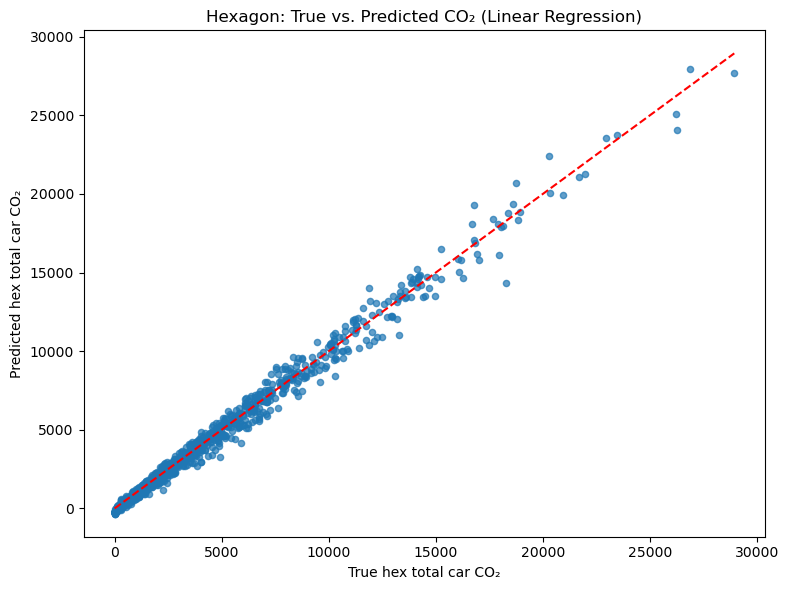

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

# 1. Load data
# in last cell

# 2. Aggregate by origin hexagon (sum CO₂, mean/sum other features)
hex_group = (
    df.groupby(['ORIGIN_CODE9', 'ORIGIN_Municipality'])
      .agg(
          total_car_co2=('car_co2_locomizer', 'sum'),
          avg_speed=('avg_speed', 'mean'),
          n_traffic_signals=('n_traffic_signals', 'mean'),  # or sum if preferred
          stop_count=('stop_count', 'mean'),
          total_distance=('car_dist', 'sum'),  # or 'mean'
          total_time=('car_time', 'sum'),      # or 'mean'
          shortest_distance_m=('shortest_distance_m', 'mean'),
          population=('population', 'first'),
          total_built_area=('total_built_area', 'first')
      )
      .reset_index()
)

# 3. Split by municipality
test_df = hex_group[hex_group['ORIGIN_Municipality'].str.lower() == 'helsinki'].reset_index(drop=True)
train_df = hex_group[hex_group['ORIGIN_Municipality'].str.lower() == 'espoo'].reset_index(drop=True)

# 4. Features/target
cat_features = ['ORIGIN_CODE9']
numerical_features = ['avg_speed', 'n_traffic_signals', 'stop_count',
                      'shortest_distance_m', 'total_distance', 'total_time',
                      'population', 'total_built_area']
target = 'total_car_co2'
all_features = cat_features + numerical_features + [target]

# 5. Drop NAs
train_sample = train_df.dropna(subset=all_features)
test_sample = test_df.dropna(subset=all_features)

# 6. Encode
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_sample[cat_features] = enc.fit_transform(train_sample[cat_features])
test_sample[cat_features] = enc.transform(test_sample[cat_features])

# 7. Prepare for ML
X_train = train_sample[cat_features + numerical_features].values
y_train = train_sample[target].values

X_test = test_sample[cat_features + numerical_features].values
y_test = test_sample[target].values

# 8. Fit model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 9. Metrics & outputs
print("Test set size:", len(y_test))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

# 10. Save predictions
output_df = pd.DataFrame({
    "true_hex_car_co2": y_test,
    "predicted_hex_car_co2": y_pred
})
output_df.to_csv("hex_car_co2_predictions.csv", index=False)
print("Predictions saved as hex_car_co2_predictions.csv")

# 11. Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, s=20, alpha=0.7)
plt.xlabel("True hex total car CO₂")
plt.ylabel("Predicted hex total car CO₂")
plt.title("Hexagon: True vs. Predicted CO₂ (Linear Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()


Feature importances (numerical features only):
avg_speed             :  3.31
n_traffic_signals     : -4.39
stop_count            : -1.22
shortest_distance_m   :  0.0246
total_distance        :  0.0135
total_time            : -1.32
population            :  0.031
total_built_area      :  0.00236


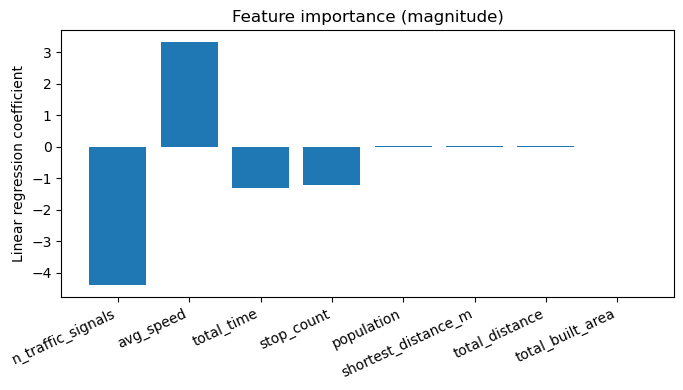

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get all feature names (categorical + numerical)
all_feature_names = cat_features + numerical_features

# 2. Get coefficients
coefs = model.coef_

# 3. Print coefficients for numerical features only (skip hexagon IDs)
num_idx = [all_feature_names.index(f) for f in numerical_features]
num_coefs = coefs[num_idx]

print("Feature importances (numerical features only):")
for name, coef in zip(numerical_features, num_coefs):
    print(f"{name:22s}: {coef: .3g}")

# 4. Plot
plt.figure(figsize=(7,4))
sorted_idx = np.argsort(np.abs(num_coefs))[::-1]
plt.bar([numerical_features[i] for i in sorted_idx], num_coefs[sorted_idx])
plt.xticks(rotation=25, ha='right')
plt.ylabel('Linear regression coefficient')
plt.title('Feature importance (magnitude)')
plt.tight_layout()
plt.show()


Saved predicted Helsinki hex CO2 to helsinki_hex_predicted_car_co2.csv


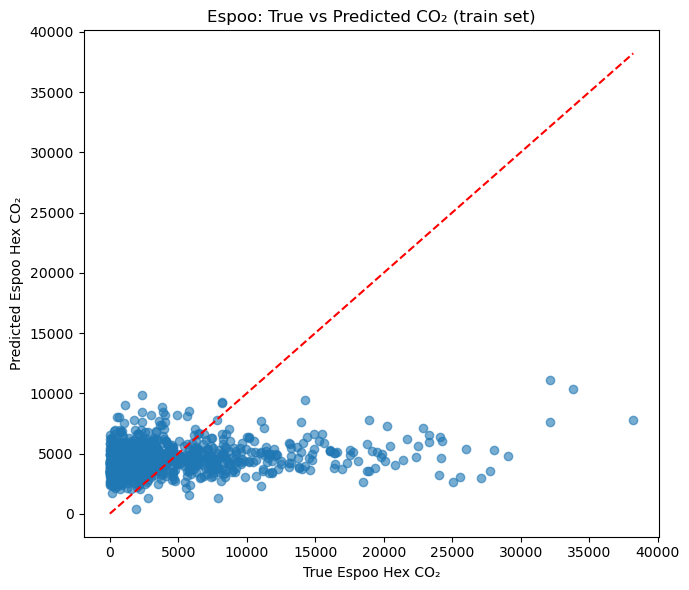

Linear model coefficients:
population          : 1.716
avg_speed           : -34.507
n_traffic_signals   : -73.946
stop_count          : -84.336
total_built_area    : 0.045


In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt

# --- 1. Load Data ---
df_trips = pd.read_csv(r"locomizer_data_complete.csv")  # update with actual file name
df_hex = pd.read_csv("hex_attributes_combined.csv")  # update as needed

# --- 2. Aggregate emissions per hexagon ---
# Only keep trips with valid CO₂ value
df_trips = df_trips.dropna(subset=['car_co2_locomizer', 'ORIGIN_CODE9'])

# Sum CO₂ emissions for all trips starting from each origin hex
emissions_per_hex = df_trips.groupby('ORIGIN_CODE9')['car_co2_locomizer'].sum().reset_index()
emissions_per_hex = emissions_per_hex.rename(columns={'ORIGIN_CODE9': 'hex_id', 'car_co2_locomizer': 'total_car_co2'})

# --- 3. Merge with hex features ---
hex_df = df_hex.copy()
hex_df['hex_id'] = hex_df['hex_id'].astype(str)
merged = emissions_per_hex.merge(hex_df, on='hex_id', how='left')

# --- 4. Attach municipality info (if not already present) ---
# (If you have municipality info separately, join it in, else skip)
if 'ORIGIN_Municipality' in df_trips.columns:
    # If municipality comes from trips data, attach (you can change this block as needed)
    muni = df_trips[['ORIGIN_CODE9', 'ORIGIN_Municipality']].drop_duplicates()
    muni = muni.rename(columns={'ORIGIN_CODE9': 'hex_id'})
    merged = merged.merge(muni, on='hex_id', how='left')

# --- 5. Split into train (Espoo) and predict (Helsinki) ---
train = merged[merged['ORIGIN_Municipality'].str.lower() == 'espoo'].copy()
test = merged[merged['ORIGIN_Municipality'].str.lower() == 'helsinki'].copy()

# --- 6. Select features and drop missing ---
features = ['population', 'avg_speed', 'n_traffic_signals', 'stop_count', 'total_built_area']  # Add more as desired
target = 'total_car_co2'

train = train.dropna(subset=features + [target])
test = test.dropna(subset=features)

X_train = train[features].values
y_train = train[target].values
X_test = test[features].values

# --- 7. Train model and predict ---
model = LinearRegression()
model.fit(X_train, y_train)
test['predicted_car_co2'] = model.predict(X_test)

# --- 8. Save results ---
test[['hex_id', 'predicted_car_co2'] + features].to_csv('helsinki_hex_predicted_car_co2.csv', index=False)
print("Saved predicted Helsinki hex CO2 to helsinki_hex_predicted_car_co2.csv")

# --- 9. Optional: Plot true vs. predicted for Espoo train set
y_train_pred = model.predict(X_train)
plt.figure(figsize=(7,6))
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.xlabel("True Espoo Hex CO₂")
plt.ylabel("Predicted Espoo Hex CO₂")
plt.title("Espoo: True vs Predicted CO₂ (train set)")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.tight_layout()
plt.show()

# --- 10. Feature importances
print("Linear model coefficients:")
for name, coef in zip(features, model.coef_):
    print(f"{name:20s}: {coef:.3f}")



In [12]:
print(df_trips.columns)


Index(['Unnamed: 0', 'ORIGIN_CODE9', 'DESTINATION_CODE9',
       'EXTRAPOLATED_NUMBER_OF_USERS', 'car_dist', 'car_time', 'car_co2',
       'pt_dist', 'pt_time', 'pt_co2', 'ORIGIN_Municipality',
       'DESTINATION_Municipality', 'geometry', 'geometry_destination',
       'car_user_share', 'pt_user_share', 'car_user', 'pt_user',
       'car_co2_locomizer', 'pt_co2_locomizer', 'od_pair',
       'shortest_distance_m', 'one'],
      dtype='object')


In [13]:
df_hex.columns

Index(['hex_id', 'population', 'avg_speed', 'n_traffic_signals',
       'total_built_area', 'stop_count'],
      dtype='object')

Saved predicted Helsinki hex CO2 to helsinki_hex_predicted_car_co2.csv


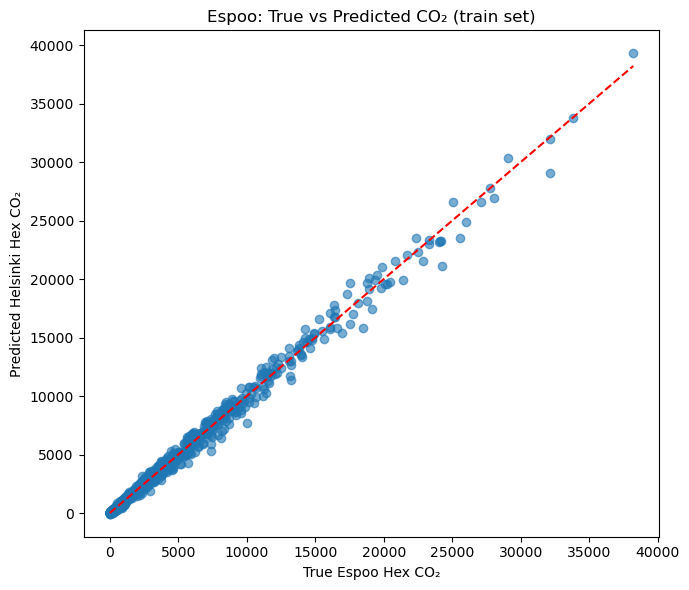

Linear model coefficients:
population          : -0.004
avg_speed           : 2.952
n_traffic_signals   : -4.573
total_built_area    : 0.004
stop_count          : -1.880
total_car_dist      : 0.011
total_car_time      : 0.276
total_shortest_dist : 0.001
no_of_trips         : -25.303

Test set size: 1208
MSE: 170880.53688959352
R^2: 0.9909660078544101


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Load data
df_trip = pd.read_csv("locomizer_data_complete.csv")
df_hex = pd.read_csv("hex_attributes_combined.csv")
df_trip['one'] = 1

# 2. Aggregate only these per origin hexagon
agg_funcs = {
    'car_co2_locomizer': 'sum',
    'car_dist': 'sum',
    'car_time': 'sum',
    'shortest_distance_m': 'sum',
    'one': 'sum'   # total number of trips
}
grouped = (
    df_trip
    .groupby('ORIGIN_CODE9')
    .agg(agg_funcs)
    .rename(columns={
        'car_co2_locomizer': 'total_car_co2',
        'car_dist': 'total_car_dist',
        'car_time': 'total_car_time',
        'shortest_distance_m': 'total_shortest_dist',
        'one': 'no_of_trips'
    })
    .reset_index()
    .rename(columns={'ORIGIN_CODE9': 'hex_id'})
)

# 3. Merge static attributes from df_hex
merged = grouped.merge(df_hex, on='hex_id', how='left')

# 4. Attach municipality info
if 'ORIGIN_Municipality' in df_trip.columns:
    muni = df_trip[['ORIGIN_CODE9', 'ORIGIN_Municipality']].drop_duplicates().rename(
        columns={'ORIGIN_CODE9': 'hex_id'}
    )
    merged = merged.merge(muni, on='hex_id', how='left')

# 5. Split by municipality
train = merged[merged['ORIGIN_Municipality'].str.lower() == 'espoo'].copy()
test = merged[merged['ORIGIN_Municipality'].str.lower() == 'helsinki'].copy()

# 6. Features for ML
features = [
    'population', 'avg_speed', 'n_traffic_signals', 'total_built_area', 'stop_count',
    'total_car_dist', 'total_car_time', 'total_shortest_dist', 'no_of_trips'
]

# features = [
#     'population', 'avg_speed', 'n_traffic_signals', 'total_built_area', 'stop_count',
#     'total_car_dist', 'total_car_time', 'no_of_trips'
# ]

# features = [
#     'population', 'avg_speed', 'n_traffic_signals', 'total_built_area', 'stop_count', 'total_shortest_dist', 'no_of_trips'
# ]

target = 'total_car_co2'

train = train.dropna(subset=features + [target])
test = test.dropna(subset=features)

X_train = train[features].values
y_train = train[target].values
X_test = test[features].values

# 7. Train and predict
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test['predicted_car_co2'] = y_pred

# 8. Save results
test[['hex_id', 'predicted_car_co2'] + features].to_csv('helsinki_hex_predicted_car_co2.csv', index=False)
print("Saved predicted Helsinki hex CO2 to helsinki_hex_predicted_car_co2.csv")

# 9. Optional: plot true vs predicted for Espoo (train set)
y_train_pred = model.predict(X_train)
plt.figure(figsize=(7,6))
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.xlabel("True Espoo Hex CO₂")
plt.ylabel("Predicted Helsinki Hex CO₂")
plt.title("Espoo: True vs Predicted CO₂ (train set)")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.tight_layout()
plt.show()

# 10. Feature importances
print("Linear model coefficients:")
for name, coef in zip(features, model.coef_):
    print(f"{name:20s}: {coef:.3f}")

# 11. Print test set metrics
print(f"\nTest set size: {len(y_pred)}")
print("MSE:", mean_squared_error(test[target], y_pred))
print("R^2:", r2_score(test[target], y_pred))


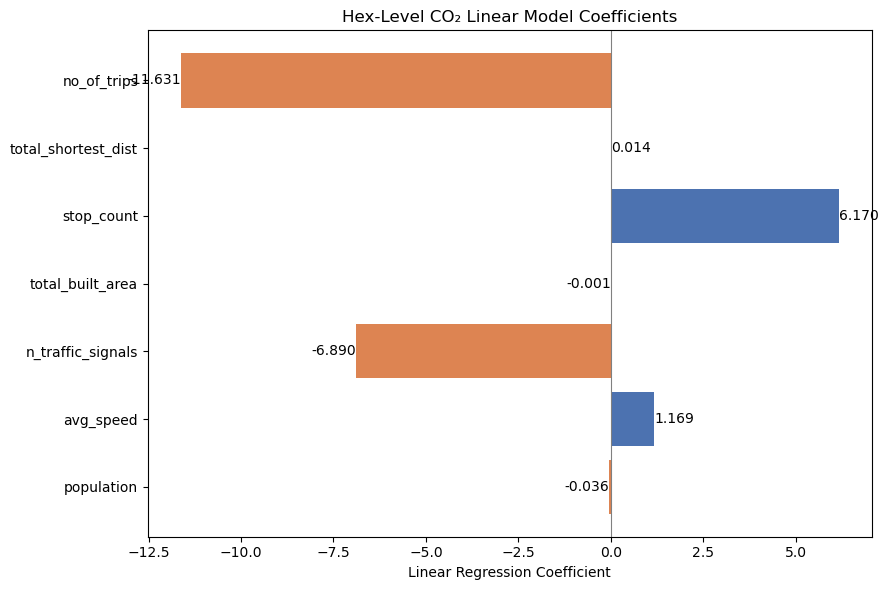

In [18]:
import matplotlib.pyplot as plt

features = [
    'population', 'avg_speed', 'n_traffic_signals', 'total_built_area', 'stop_count',
    'total_shortest_dist', 'no_of_trips'
]
coefs = [
    -0.036, 1.169, -6.890, -0.001, 6.170, 0.014, -11.631
]

plt.figure(figsize=(9, 6))
bars = plt.barh(features, coefs, color=["#4c72b0" if c >= 0 else "#dd8452" for c in coefs])
plt.xlabel("Linear Regression Coefficient")
plt.title("Hex-Level CO₂ Linear Model Coefficients")

# Annotate
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.3f}", va='center',
             ha='left' if bar.get_width() > 0 else 'right',
             color='black', fontsize=10)

plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()
